# DS Lab assignment 5

## Group Members

• Aniket Thakur (Roll No.: 24BM6JP05)  
• Mohsin Parmar (Roll No.: 24BM6JP33)  
• Pabbaraju Sai Shanmukha Sri Harsha (Roll No.: 24BM6JP38)  
• Rahul Verma (Roll No.: 24BM6JP44)  
• Sachin Goyal (Roll No.: 24BM6JP46)


**Objective of the Assignment**
The goal of this assignment is to build a text classification model that predicts the sentiment (Neutral, Positive, or Negative) of a given news headline. The dataset is sourced from Kaggle and consists of financial news headlines labeled with sentiment categories.

**Key Steps performed in the notebook**
1.   Exploratory Data Analysis (EDA) to understand the dataset structure
2.   Preprocess text data to remove unnecessary noise and enhance model performance
3.   Convert text into numerical representations using TF-IDF.
4.   Train and optimize an XGBoost model to classify news headlines accurately.
5.   Evaluate model performance using classification metrics and a confusion matrix.

In [24]:
# Importing necessary libraries

# Data manipulation and numerical computation
import pandas as pd
import numpy as np
import scipy.sparse as sp

# Fetching data from Kaggle
import kagglehub

# Data visualization libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis
import scipy.stats as stats

# Text processing and NLP tools
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine learning model training and hyperparameter tuning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Evaluation metrics for model performance
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [25]:
# Downloading the necessary dependancies of nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 1. Data Exploration and Visualisation

In [26]:
# Loading the dataset
path = kagglehub.dataset_download("ankurzing/sentiment-analysis-for-financial-news")

# Loading the dataset
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ankurzing/sentiment-analysis-for-financial-news/versions/5


In [27]:
# Importing necessary libraries
file_path = str(path+'/all-data.csv')
fin_txt_df = pd.read_csv(file_path,delimiter=',',encoding='latin1',header=None)

# Renaming the dataframe headers
fin_txt_df.columns = ['Sentiment','News_Headline']

# Viewing the top 10 rows
fin_txt_df.head(10)

,Sentiment,News_Headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
5,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
6,positive,"For the last quarter of 2010 , Componenta 's n..."
7,positive,"In the third quarter of 2010 , net sales incre..."
8,positive,Operating profit rose to EUR 13.1 mn from EUR ...
9,positive,"Operating profit totalled EUR 21.1 mn , up fro..."


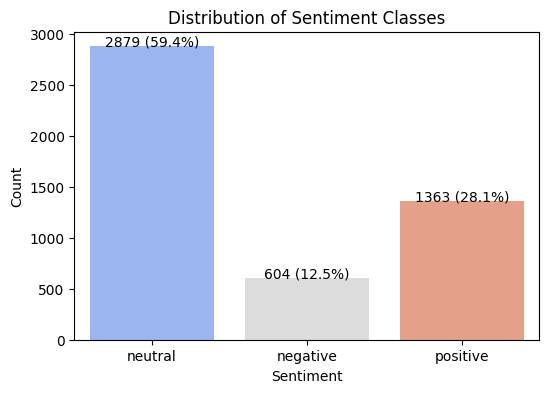

In [28]:
# Getting the number of occurrences for each sentiment
sentiment_counts = fin_txt_df['Sentiment'].value_counts()
total = len(fin_txt_df)  # Total number of rows

# For the count plot
plt.figure(figsize=(6,4))
ax = sns.countplot(x=fin_txt_df['Sentiment'], hue=fin_txt_df['Sentiment'], palette='coolwarm', legend=False)

# Annotating the bars with count & percentage
for p in ax.patches:
    height = p.get_height()  # Get bar height
    percentage = f"{height / total * 100:.1f}%"  # Compute percentage
    ax.text(p.get_x() + p.get_width()/2., height + 2, f'{int(height)} ({percentage})',
            ha='center', fontsize=10)

# Formatting of the chart
plt.title("Distribution of Sentiment Classes")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

The neutral class dominates with 2,879 instances (59.4%), followed by positive with 1,363 (28.1%), and negative with 604 (12.5%). The chart highlights a class imbalance, where neutral sentiments are significantly more frequent. This imbalance may affect machine learning models, making them biased toward the dominant class. We could have done SMOTE but we haven't done this which will result in biased result.

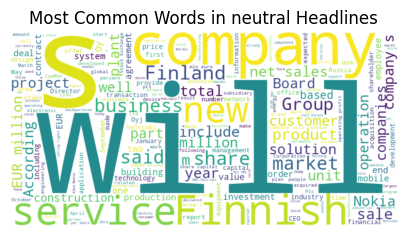

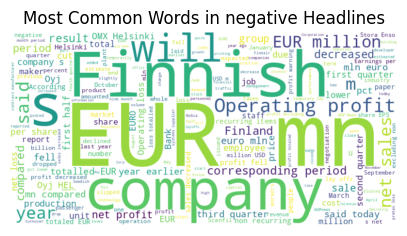

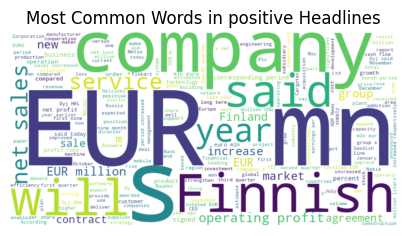

In [29]:
# Function to generate WordCloud
def plot_wordcloud(sentiment):
    text = " ".join(fin_txt_df[fin_txt_df['Sentiment'] == sentiment]['News_Headline'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(5,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most Common Words in {sentiment} Headlines")
    plt.show()

# Generating word clouds for each sentiment
for sentiment in fin_txt_df['Sentiment'].unique():
    plot_wordcloud(sentiment)

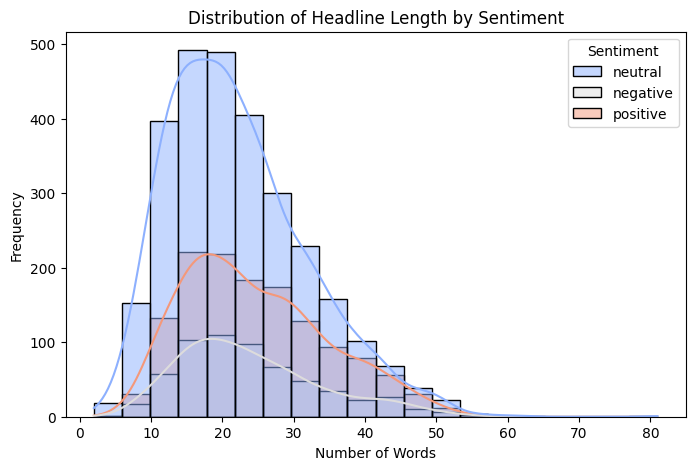

In [30]:
# Adding a column for headline length
fin_txt_df['Headline_Length'] = fin_txt_df['News_Headline'].apply(lambda x: len(x.split()))

# Plotting the distribution
plt.figure(figsize=(8,5))
sns.histplot(data=fin_txt_df, x='Headline_Length', hue='Sentiment', kde=True, bins=20, palette='coolwarm')
plt.title("Distribution of Headline Length by Sentiment")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

The x-axis represents word count, while the y-axis shows frequency. The neutral class has the highest frequency, peaking around 20 words. Positive headlines are shorter on average, clustering at 15-30 words, while negative headlines are more spread out. The density curves highlight differences in word usage across sentiment types. The visualization provides insights into sentiment-based text length variations.

# 2. Text Pre-Processing and Feature Engineering

In [31]:
# Define a function to pre-process text columns
def preprocess_text(text):
  text = text.lower()
  text = re.sub(f"[{string.punctuation}]", "", text)
  words = word_tokenize(text)
  words = [word for word in words if word not in stopwords.words("english")]
    # stemmer = PorterStemmer()
  # words = [stemmer.stem(word) for word in words] # Perform word stemming
  lemmatizer = WordNetLemmatizer()
  words = [lemmatizer.lemmatize(word) for word in words]
  return " ".join(words)

This function pre-processes text data by converting it to lowercase, removing punctuation, tokenizing words, and filtering out stop words. It then applies lemmatization (or optionally stemming) to standardize word forms before returning the cleaned text.

In [32]:
def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

In [33]:
# Create a new text column after applying pre-processing
fin_txt_df['Processed_Txt'] = fin_txt_df['News_Headline'].astype(str).apply(preprocess_text)

Creating a new column called 'Processed_Txt' which is a cleaner version of the column 'News_Headline'

In [34]:
# Splitting data into training and testing sets
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(fin_txt_df['Processed_Txt'])
y = fin_txt_df['Sentiment']

Creating word embeddings using TFIDF vectorizer on the processed_txt column for feeding into our Decision Tree model

# 3. Training Model and Evaluating Performance

### Decision Stump

In [35]:
# Splitting data into training and testing sets (80-20 split)
X_train, X_test,y_train,y_test = train_test_split(X,y,random_state = 42,test_size=0.2)

0.6175257731958763
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       110
     neutral       0.63      0.98      0.77       571
    positive       0.45      0.13      0.20       289

    accuracy                           0.62       970
   macro avg       0.36      0.37      0.32       970
weighted avg       0.51      0.62      0.51       970



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


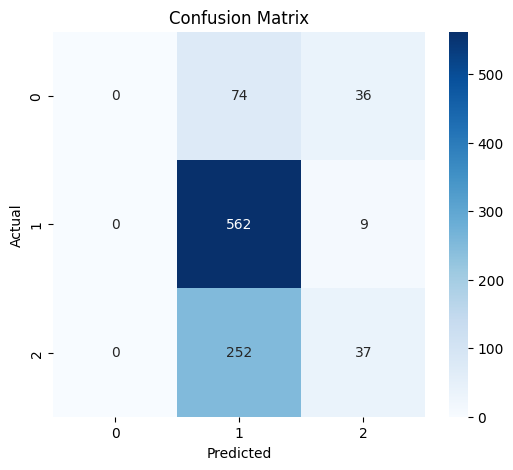

In [36]:
# Initiate a decision stump of max depth 1
stump = DecisionTreeClassifier(max_depth = 1, random_state = 42)

# Train Decision Stump
stump.fit(X_train,y_train)

# Predict
stump_preds = stump.predict(X_test)

# Evaluate the Decision Stump performance
print(accuracy_score(y_test,stump_preds))
cm = confusion_matrix(y_test,stump_preds)
print(classification_report(y_test,stump_preds))
plot_confusion_matrix(cm)

The classification report shows an accuracy of 62%, but performance is imbalanced. The model fails to classify negative instances (F1-score: 0.00) and struggles with positive sentiment (F1-score: 0.20, recall: 0.13). It performs best on the neutral class (F1-score: 0.77, recall: 0.98), indicating bias towards it. The macro F1-score of 0.32 highlights poor overall balance. The model suffers from class imbalance in training dataset, misclassifying many positive and negative cases.

After the poor performance of the Decision Stump, especially in handling class imbalance, we applied AdaBoost to improve classification. By combining multiple weak learners, AdaBoost enhanced overall accuracy and better captured minority class patterns.

### AdaBoost Classifier

AdaBoost Accuracy: 0.6381443298969072
              precision    recall  f1-score   support

    negative       0.95      0.18      0.31       110
     neutral       0.63      0.98      0.77       571
    positive       0.60      0.13      0.21       289

    accuracy                           0.64       970
   macro avg       0.73      0.43      0.43       970
weighted avg       0.66      0.64      0.55       970



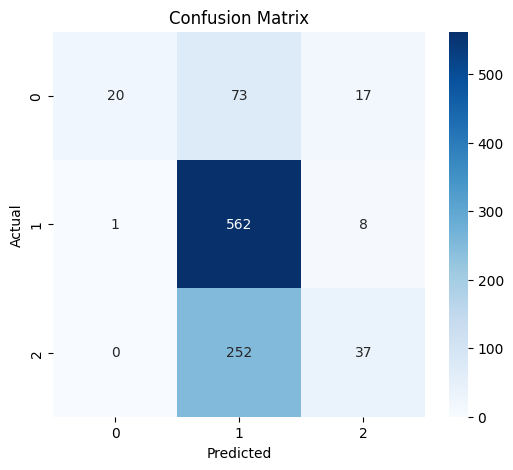

In [37]:
# AdaBoost Classifier
adaboost = AdaBoostClassifier(estimator=stump, n_estimators=50)

# Train Adaboost Classifier
adaboost.fit(X_train, y_train)

# Predict
adaboost_preds = adaboost.predict(X_test)

# Evaluate the Adaboost model performance
print("AdaBoost Accuracy:", accuracy_score(y_test, adaboost_preds))
cm = confusion_matrix(y_test,adaboost_preds)
print(classification_report(y_test,adaboost_preds))
plot_confusion_matrix(cm)

The AdaBoost model achieves 64% accuracy, improving upon the Decision Stump but slightly underperforming compared to XGBoost. The neutral class is predicted best (F1-score: 0.77, recall: 0.98), while negative (F1-score: 0.31, recall: 0.18) and positive (F1-score: 0.21, recall: 0.13) classes are more frequently misclassified. The model struggles with positive sentiment detection, similar to previous models.

 While AdaBoost improved accuracy, it struggled with positive sentiment detection and class imbalance. XGBoost, with its advanced gradient boosting approach and better handling of misclassifications, helped improve overall precision, recall, and F1-scores, making it a more robust choice for sentiment analysis.

### XGBoost

XGBoost Accuracy: 0.7721649484536083
              precision    recall  f1-score   support

           0       0.76      0.55      0.63       110
           1       0.77      0.93      0.85       571
           2       0.78      0.54      0.64       289

    accuracy                           0.77       970
   macro avg       0.77      0.67      0.71       970
weighted avg       0.77      0.77      0.76       970



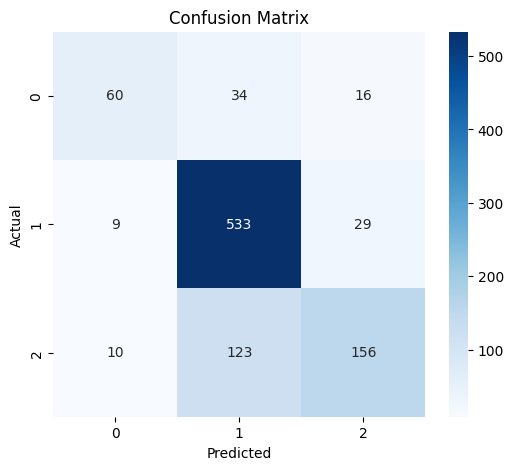

In [38]:
# Encode string labels into integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train XGBoost with numeric labels
xgb = XGBClassifier(eval_metric="mlogloss",objective = 'multi:softmax')
xgb.fit(X_train, y_train_encoded)

# Predict
xgb_preds = xgb.predict(X_test)

# Convert predictions back to original labels
xgb_preds_labels = label_encoder.inverse_transform(xgb_preds)

# Evaluate the XGBoost model performance
print("XGBoost Accuracy:", accuracy_score(y_test_encoded, xgb_preds))
cm = confusion_matrix(y_test_encoded, xgb_preds)
print(classification_report(y_test_encoded, xgb_preds))
plot_confusion_matrix(cm)

The XGBoost model achieves 77% accuracy, showing significant improvement over previous models. The neutral class is classified best (F1-score: 0.85, recall: 0.93), while negative (F1-score: 0.65, recall: 0.56) and positive (F1-score: 0.63, recall: 0.55) classes are more frequently misclassified as neutral. The confusion matrix indicates that most errors involve extreme sentiments (negative or positive) being classified as neutral, suggesting the model struggles with sentiment polarity. Further improvements could include hyperparameter tuning, handling class imbalance using resampling techniques, or employing transformer-based NLP models to better capture sentiment nuances and enhance the distinction between sentiment classes.

# 4. XGBoost Hyper-Parmeter Tuning

To further optimize XGBoost, we applied Grid Search to fine-tune its hyperparameters. This helped in improving model performance by finding the best combination of parameters, such as learning rate, max depth, and number of estimators, ensuring better generalization. Fine-tuning allowed XGBoost to handle class imbalances more effectively and improve sentiment classification accuracy.

In [ ]:
# Define parameter distributions
param_dist = {
    'max_depth': np.arange(3, 10),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'num_boost_rounds': np.arange(100, 1000, 100),
    'gamma': np.linspace(0, 0.5, 10),
    'colsample_bytree': np.linspace(0.5, 1.0, 10),
    'lambda': np.logspace(-2, 1, 10),
    'alpha': np.logspace(-2, 1, 10),

}

# Initialize XGBoost model
xgb_model = XGBClassifier()

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    scoring='accuracy',
    n_iter=5,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    random_state=42
)

C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [15:31:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "num_boost_rounds" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters Found: {'num_boost_rounds': 600, 'max_depth': 3, 'learning_rate': 0.2677777777777778, 'lambda': 1.0, 'gamma': 0.2222222222222222, 'colsample_bytree': 0.7777777777777778, 'alpha': 0.1}
XGBoost Accuracy: 0.7577319587628866
              precision    recall  f1-score   support

           0       0.81      0.51      0.63       110
           1       0.74      0.96      0.84       571
           2       0.80      0.45      0.58       289

    accuracy                           0.76       970
   macro avg       0.79      0.64      0.68       970
weighted avg       0.77      0.76      0.74       970



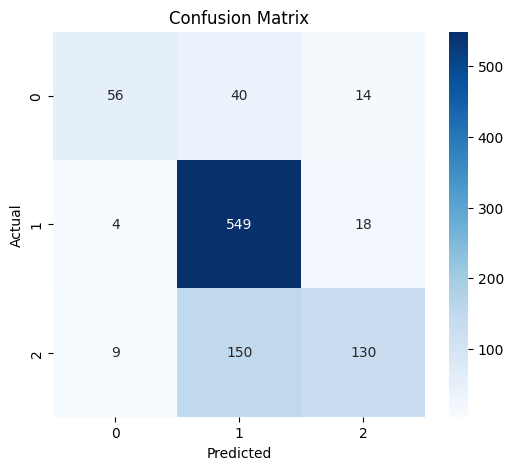

In [ ]:
# Fit RandomizedSearchCV
random_search.fit(X_train, y_train_encoded)

# Print best parameters
print("Best Parameters Found:", random_search.best_params_)

# Training the model on the dataset
best_xgb = random_search.best_estimator_

# Predict on test set
best_xgb_preds = best_xgb.predict(X_test)
# Evaluate the XGBoost model performance
print("XGBoost Accuracy:", accuracy_score(y_test_encoded, best_xgb_preds))
cm = confusion_matrix(y_test_encoded, best_xgb_preds)
print(classification_report(y_test_encoded, best_xgb_preds))
plot_confusion_matrix(cm)

We could not observe any noticeable model improvement with the hyper-parameter tuning. So, we shall explore another way in the next part to improve our accuracy

# 5. Augmenting input features with financial/sentiment keywords

Now, we understand that for this application of sentiment analysis, XGBoost algorithm is performing better compared to Decision stump and Adaboost. So, we shall fix XGBoost model as our final model selected and augment our input features further

In [39]:
# Define financial and sentiment-related keywords
financial_keywords = {
    "profit", "loss", "revenue", "growth", "decline", "investment", "stock",
    "market", "economy", "inflation", "debt", "bankruptcy", "finance",
    "earnings", "dividends", "merger", "acquisition", "funding", "capital",
    "asset", "valuation", "interest", "return", "yield", "credit", "bond",
    "liquidity", "equity", "hedge", "portfolio", "derivative", "leverage",
    "forex", "exchange", "index", "commodity", "futures", "options",
    "securities", "shares", "insolvency", "overdraft", "risk", "volatility"
}

sentiment_keywords = {
    "good", "bad", "positive", "negative", "increase", "decrease", "risk",
    "opportunity", "strong", "weak", "high", "low", "improve", "drop",
    "gain", "fall", "success", "failure", "confidence", "concern",
    "optimistic", "pessimistic", "stable", "unstable", "secure", "insecure",
    "trust", "doubt", "boom", "crash", "expansion", "recession", "bullish",
    "bearish", "surge", "plunge", "collapse", "stability", "reliability",
    "uncertain", "speculative", "prosperity", "crisis", "fluctuate", "stagnant"
}

# Extract text and labels
X_text = fin_txt_df['News_Headline'].astype(str)
y = fin_txt_df['Sentiment'] # Sentiment labels

# Function to count keyword occurrences
def count_keywords(text, keyword_set):
    words = text.lower().split()
    return sum(word in keyword_set for word in words)

# Compute keyword counts
X_financial = X_text.apply(lambda x: count_keywords(x, financial_keywords))
X_sentiment = X_text.apply(lambda x: count_keywords(x, sentiment_keywords))

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X_text)

# Combine features
X_combined = sp.hstack((X_tfidf, X_financial.values.reshape(-1, 1), X_sentiment.values.reshape(-1, 1)))

Once we add financial and sentiment keywords to our input dataset as additional features, we then again perform training and testing followed by XGBoost for predicting our model

XGBoost Accuracy: 0.7804123711340206
              precision    recall  f1-score   support

           0       0.81      0.57      0.67       110
           1       0.77      0.94      0.85       571
           2       0.81      0.55      0.65       289

    accuracy                           0.78       970
   macro avg       0.79      0.69      0.72       970
weighted avg       0.79      0.78      0.77       970



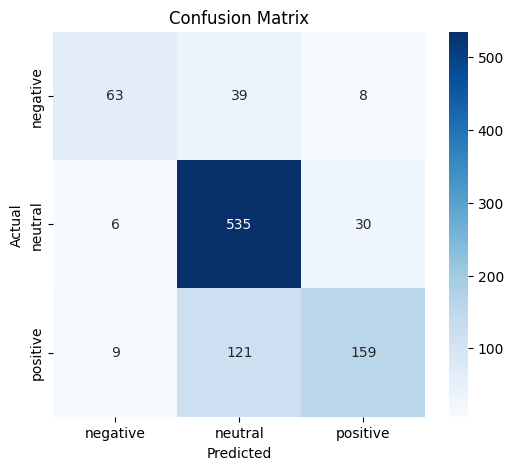

In [40]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Encode string labels into integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train XGBoost with numeric labels
xgb = XGBClassifier(eval_metric="mlogloss", objective='multi:softmax')
xgb.fit(X_train, y_train_encoded)

# Predict
xgb_preds = xgb.predict(X_test)

# Convert predictions back to original labels
xgb_preds_labels = label_encoder.inverse_transform(xgb_preds)

# Evaluate the XGBoost model performance
print("XGBoost Accuracy:", accuracy_score(y_test_encoded, xgb_preds))
cm = confusion_matrix(y_test_encoded, xgb_preds)
print(classification_report(y_test_encoded, xgb_preds))

def plot_confusion_matrix(cm):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(cm)

We are achieving an accuracy of 78% after enriching our dataset with additional features for financial and sentiment keywords before feeding into XGBoost model. The neutral class (F1-score: 0.85, recall: 0.94) is classified most effectively, while the positive (F1-score: 0.65, recall: 0.55) and negative (F1-score: 0.67, recall: 0.57) classes exhibit higher misclassification rates, often being predicted as neutral. The confusion matrix highlights that the model struggles with distinguishing extreme sentiments, likely due to overlapping vocabulary or sentiment ambiguity in financial news headlines. Further refinements could include class balancing techniques, hyperparameter tuning, and context-aware embeddings like FinBERT, which could enhance the model’s ability to differentiate subtle sentiment variations and improve classification precision for positive and negative classes.

**Overall Summary**

We aimed to develop a robust sentiment classification model for financial news headlines, categorizing them into positive, negative, or neutral sentiments. To achieve this, we followed the below flow: I first preprocessed the dataset by

*   Preprocessed the dataset by tokenizing text, removing stopwords, and applying TF-IDF vectorization to convert textual data into numerical features
*   Explored Decision stump, Adaboost and XGBoost models to see which would provide the best accuracy settling at XGBoost model which gives 77% accuracy
*   Explored hyper-parameter tuning in XGBoost
*   Then we incorporated commonly used financial and sentiment keywords corpus as additional features into our XGBoost model which improved overall accuracy to 78%
The results demonstrated that integrating financial-specific keywords alongside traditional TF-IDF features improved classification accuracy, reinforcing the importance of domain-aware feature engineering in sentiment analysis.